# Homework 4: Image Classification

**Name:** 

In [ ]:
Name = "Hari Chandana Kotnani"
assert Name != "", 'Please enter your name, thanks!'

**A-Number:** 

In [ ]:
A_number = "A02396013"
assert A_number != "", 'Please enter your A-number, thanks!'

**Kaggle-UserName:**

In [ ]:
Kaggle_UserName = "harichandanakotnani"
assert Kaggle_UserName != "", 'Please enter your Kaggle Username, thanks!'

In this homework, we will train a CNN model on EuroSAT. EuroSAT is a dataset consisting of images of the Earth provided by the Sentinel-2 satellite. The dataset contains ten types of images, so it is a dataset for multiclass classification. You can find more information about EuroSAT [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8736785).

 **Please download the dataset from the [inclass Kaggle competition](https://www.kaggle.com/t/9642f138df72494ea456f05b0a70a4b0) as we split the original dataset into the train-valid-test sets.**

This notebook contains a baseline model to train on EuroSAT. Please use it as a starting point. **The purpose of this homework is to design an advanced CNN model to achieve better performance on EuroSAT by yourself. You are not allowed to import pre-trained models. In case you are interested, we provide a sample code by using a pre-trained model, Resnet50.** 

Your jobs 

1.   Read, complete, and run the code.

2.   **Make substantial improvements** to maximize the accurcy.

3.   Submit the .IPYNB file to Canvas.
    - Missing the output after execution may hurt your grade.

4.   Submit the generated "pred.csv" to the [inclass Kaggle competition](https://www.kaggle.com/t/9642f138df72494ea456f05b0a70a4b0).


# **Rules**

- You should finish your homework on your own.
- **You should not modify your prediction files manually.**
- Do not share codes or prediction files with any living creatures.
- **Do not search or use additional data.**
- **Do not use any pre-trained models.**


## Hints to Improve Your Results

* You'd better use a GPU machine to run it, otherwise it'll be quite slow.
* Revise the simple CNN model
* Revise the *transforms* function by using some image augumentation techniques
* Tune hyper-parameters, such as batch_size

**Please describe your improvements here**:

1. Implemented Batch Normalization 2d for convolution and 1d for linear layers
2. Increased Fully connected layers 
3. Increased the batch size to 128 




First, import the packages or modules required for the competition.

In [ ]:
import os
import pandas as pd
import shutil
import time
from copy import deepcopy

device = 'cuda'
import torchvision.models as models

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

### Download the dataset to Colab from Kaggle. 

**You need to have your Kaggle Token at hand**. Please find [this article](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) for details.

In [ ]:
from os.path import exists
# I added this if statement to make it easier to run all cells without having to re-upload the kaggle.json file
if not exists("kaggle.json"):
  from google.colab import files
  files.upload()   ## Upload your Kaggle token file.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c fall2022-cs5665-hw4   ## You need to join the competition first.

fall2022-cs5665-hw4.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
import zipfile
import PIL
from pathlib import Path
local_zip = 'fall2022-cs5665-hw4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

### Loading and normalizing 

Using torchvision, it’s extremely easy to load EuroSAT.

In [ ]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train images: 18900, val images: 2700, test images: 5400
trainset = torchvision.datasets.ImageFolder(root='./Dataset/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='./Dataset/val', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./Dataset/test', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('Forest', 'AnnualCrop', 'Industrial', 'Residential', 'Pasture', 
           'River', 'PermanentCrop', 'SeaLake', 'Highway', 'HerbaceousVegetation')

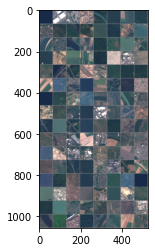

HerbaceousVegetation Pasture PermanentCrop Industrial


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)       
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 13 * 13, 240)
        self.fc1_bn = nn.BatchNorm1d(240)
        self.fc2 = nn.Linear(240, 120) 
        self.fc2_bn = nn.BatchNorm1d(120)
        self.fc3 = nn.Linear(120, 84)
        self.fc3_bn = nn.BatchNorm1d(84)
        self.fc4 = nn.Linear(84, 42) 
        self.fc4_bn = nn.BatchNorm1d(42)
        self.fc5 = nn.Linear(42, 10) 

    def forward(self, x):

        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4_bn(self.fc4(x)))
        x = self.fc5(x)
        return x


net = Net().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

## Define the Training Functions

We will select the model and tune hyper-parameters according to the model's performance on the validation set. Next, we define the model training function `train`. We record the training time of each epoch, which helps us compare the time costs of different models.

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
acc_record = {'train': [], 'dev': []} # added
for epoch in range(20):  
    net.train()
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    acc_record['train'].append(running_acc/len(trainset))  # added
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    net.eval()
    with torch.no_grad():
        for inputs,labels in valloader:
            out = net(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    acc_record['dev'].append(correct/len(valset))  # added
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(net.state_dict())
    lr_scheduler.step()
    
print('Finished Training')  

Train loss 1: 1.1218064177099358,Train Acc:66.22222222222223%
Val accuracy:66.18518518518519%
Train loss 2: 0.5936260525385538,Train Acc:82.03703703703704%
Val accuracy:82.03703703703704%
Train loss 3: 0.536346353475379,Train Acc:84.28571428571429%
Val accuracy:83.14814814814815%
Train loss 4: 0.5290415436124045,Train Acc:84.52910052910053%
Val accuracy:83.11111111111111%
Train loss 5: 0.5316636775031922,Train Acc:84.4973544973545%
Val accuracy:82.74074074074075%
Train loss 6: 0.5285859003016558,Train Acc:84.45502645502646%
Val accuracy:83.0%
Train loss 7: 0.5247196125858045,Train Acc:84.92063492063492%
Val accuracy:83.0%
Train loss 8: 0.5300931516778532,Train Acc:84.70370370370371%
Val accuracy:82.85185185185185%
Train loss 9: 0.5327925218476189,Train Acc:84.4021164021164%
Val accuracy:83.25925925925925%
Train loss 10: 0.5343265950616706,Train Acc:84.31216931216932%
Val accuracy:83.11111111111111%
Train loss 11: 0.5309601747548138,Train Acc:84.53968253968254%
Val accuracy:83.074074074

In [ ]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

## Plotting the Learning curve
I just modified the learning curve function from Homework 3. You're more than welcome to change anything you dislike.

In [ ]:
# This is mo
def plot_learning_curve(acc_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = range(len(acc_record['train']))
    x_2 = range(len(acc_record['dev']))
    figure(figsize=(6, 4))
    plt.plot(x_1, acc_record['train'], c='tab:red', label='train')
    plt.plot(x_2, acc_record['dev'], c='tab:cyan', label='dev')
    y_min = min(min(acc_record['train']), min(acc_record['dev']))
    y_max = max(max(acc_record['train']), max(acc_record['dev']))

    # TODO: feel free to change this range to see the learning curve better
    plt.ylim(max(.95*y_min-0.01, 0.5), min(1.05*y_max+0.01, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

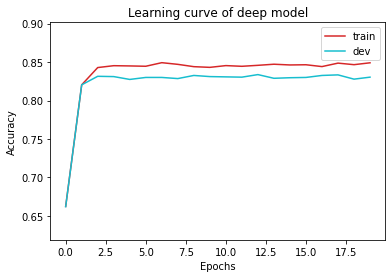

In [ ]:
plot_learning_curve(acc_record, title='deep model')

In [ ]:
%%time
preds = []
net.load_state_dict(best_val_model)
net.eval()
with torch.no_grad():
    for inputs,labels in testloader:
        out = net(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        preds.append(out.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

CPU times: user 239 ms, sys: 155 ms, total: 394 ms
Wall time: 2.54 s


In [ ]:
import csv
with open('pred.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'label'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and remove any throwaway code.
4. **Please upload the pred.csv to the [class competition](https://www.kaggle.com/competitions/fall2022-cs5665-hw4/overview).** The score of this homework is based on the result on the private datset.